# **Notebook 2: Entrenamiento, Validación y Selección de Modelos Predictivos**

**Proyecto:** Modelo Predictivo de Potencial Arqueológico (Perú)  
**Objetivo:** Entrenar algoritmos de Machine Learning (Supervisado) capaces de distinguir patrones geográficos de asentamientos arqueológicos basándose en variables ambientales.

**Flujo de Trabajo Científico:**
1.  **Configuracion del entorno y carga de datos:** Herramientas necesarias para en entrenamiento
1.  **Análisis Exploratorio de Datos (EDA):** Diagnóstico estadístico y gráfico de las variables.
2.  **Preprocesamiento:** División de datos (Train/Test) y normalización.
3.  **Modelamiento (Benchmark):** Entrenamiento comparativo de algoritmos (RF, XGBoost, SVM/LogReg).
4.  **Evaluación:** Cálculo de métricas de precisión (AUC-ROC, F1-Score, Matriz de Confusión).
5.  **Interpretabilidad:** Análisis de importancia de variables (*Feature Importance*).

### **1. Configuración del Entorno y Carga de Datos**

Se importan las librerías necesarias para el cálculo matricial, visualización estadística y modelado predictivo (`scikit-learn`, `xgboost`). Se carga el **Dataset Maestro** generado en la fase de Ingeniería de Datos.

In [1]:
# ==============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Configuración para que los outputs se vean limpios
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot') # Estilo bonito para las gráficas


# ==============================================================================
# 2. CARGA DEL DATASET
# ==============================================================================

ruta_dataset = '../data/features/dataset_entrenamiento.csv'

if os.path.exists(ruta_dataset):
    df = pd.read_csv(ruta_dataset)
    print("✅ Dataset cargado exitosamente.")
    print(f"   - Total de filas (Muestras): {df.shape[0]}")
    print(f"   - Total de columnas (Variables): {df.shape[1]}")
    
    # Revisión rápida de estructura
    print("\n--- Vista Previa ---")
    display(df.head())
    
    print("\n--- Tipos de Datos ---")
    print(df.info())
else:
    print(f"❌ Error: No se encuentra el archivo en {ruta_dataset}")

✅ Dataset cargado exitosamente.
   - Total de filas (Muestras): 27047
   - Total de columnas (Variables): 12

--- Vista Previa ---


,X_102033,Y_102033,Origen,Target,pendiente,rugosidad,dist_rios,dist_lagos,dist_qhapaq,dist_g1,dist_g2,dist_g3
0,-1.794915e+06,2.428515e+06,Sitio_Declarado,1,2.569503,3.464102,14.581225,2741.532700,33.710810,1945.14260,0.000000,35445.820
1,-1.780363e+06,2.414741e+06,Sitio_Declarado,1,4.431820,5.830952,948.773400,41.049797,1952.876800,2650.71220,1901.143100,37906.950
2,-1.778420e+06,2.414945e+06,Sitio_Declarado,1,4.727943,6.708204,83.436220,524.259600,1.394819,640.49945,0.000000,37058.110
3,-1.791737e+06,2.426272e+06,Sitio_Declarado,1,3.372287,12.124355,102.772606,2491.500200,18.457771,2501.23680,10.032484,34442.062
4,-1.806857e+06,2.438869e+06,Sitio_Declarado,1,5.788832,8.124039,585.531000,1298.819500,11.103805,15236.46200,4816.423000,41611.395



--- Tipos de Datos ---
<class 'pandas.DataFrame'>
RangeIndex: 27047 entries, 0 to 27046
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X_102033     27047 non-null  float64
 1   Y_102033     27047 non-null  float64
 2   Origen       27047 non-null  str    
 3   Target       27047 non-null  int64  
 4   pendiente    27047 non-null  float64
 5   rugosidad    27047 non-null  float64
 6   dist_rios    27047 non-null  float64
 7   dist_lagos   27047 non-null  float64
 8   dist_qhapaq  27047 non-null  float64
 9   dist_g1      27047 non-null  float64
 10  dist_g2      27047 non-null  float64
 11  dist_g3      27047 non-null  float64
dtypes: float64(10), int64(1), str(1)
memory usage: 2.5 MB
None


### **2. Análisis Exploratorio de Datos (EDA)**

Antes de entrenar, es crucial entender el comportamiento estadístico de las variables predictoras.


#### **2.1 Análisis de Correlación (Multicolinealidad)**
**Objetivo:** Detectar redundancia entre variables.  
*Figura 1:* Mapa de calor (Heatmap) de correlación de Spearman. Si dos variables tienen una correlación $>0.85$, aportan la misma información y una podría ser eliminada para reducir el ruido.


Generando Matriz de Correlación...


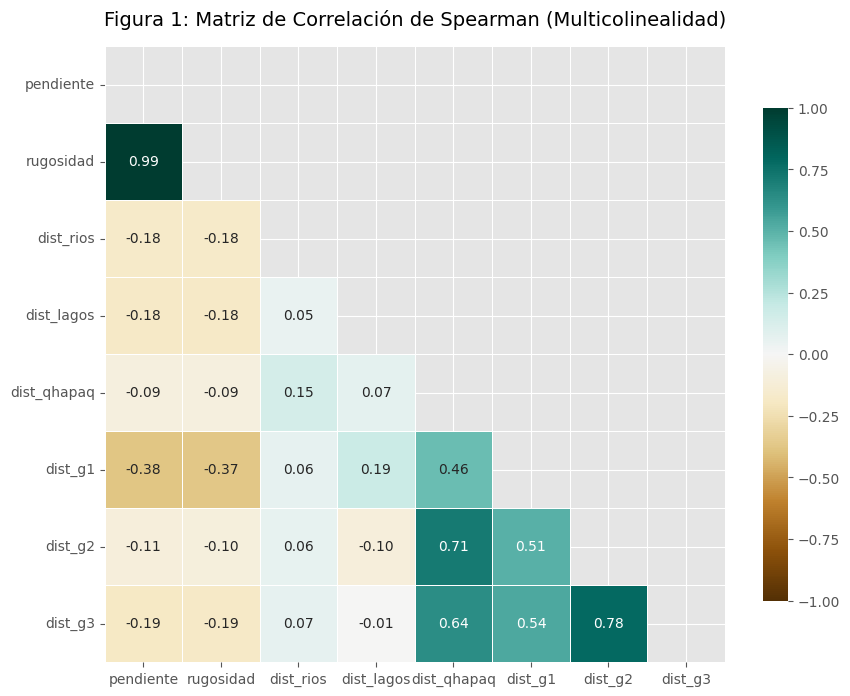

🔍 Diagnóstico de Redundancia:
⚠️ ¡ATENCIÓN! Se detectaron variables redundantes:
rugosidad  pendiente    0.994864
pendiente  rugosidad    0.994864
dtype: float64


In [2]:
# ==============================================================================
# DEFINICIÓN DE VARIABLES
# ==============================================================================
# Lista de variables predictoras (Features)
cols_features = [
    'pendiente', 'rugosidad', 
    'dist_rios', 'dist_lagos', 'dist_qhapaq', 
    'dist_g1', 'dist_g2', 'dist_g3'
]

# ==============================================================================
# 2.1 ANÁLISIS DE CORRELACIÓN (Figura 1)
# ==============================================================================
print("Generando Matriz de Correlación...")

# Calculamos Spearman (ideal para datos geográficos no lineales)
corr_matrix = df[cols_features].corr(method='spearman')

# Máscara para ocultar la mitad repetida del triángulo
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='BrBG', vmin=-1, vmax=1, center=0,
            linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('Figura 1: Matriz de Correlación de Spearman (Multicolinealidad)', fontsize=14, pad=15)
plt.show()

# Reporte automático de correlaciones altas (> 0.85)
print("🔍 Diagnóstico de Redundancia:")
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1.0] # Eliminar la diagonal
pares_altos = high_corr[high_corr > 0.85]

if len(pares_altos) > 0:
    print(f"⚠️ ¡ATENCIÓN! Se detectaron variables redundantes:\n{pares_altos}")
else:
    print("✅ No se detectó multicolinealidad severa (>0.85). Todas las variables son útiles.")

In [12]:
# ==============================================================================
# 1. CORRECCIÓN Y LIMPIEZA DE DATOS
# ==============================================================================
# A. Asegurar que Target sea número (0 y 1), no texto
df['Target'] = df['Target'].astype(int)

# B. Eliminar variable redundante del DataFrame
if 'rugosidad' in df.columns:
    df = df.drop(columns=['rugosidad'])
    print("⚠️ Variable 'rugosidad' eliminada del dataset (redundancia > 0.99).")

# C. DEFINIR LA LISTA EXACTA DE VARIABLES A GRAFICAR (SIN RUGOSIDAD)
cols_features = [
    'pendiente', 
    'dist_rios', 'dist_lagos', 'dist_qhapaq', 
    'dist_g1', 'dist_g2', 'dist_g3'
]

#### **2.2 Análisis de Separabilidad (Boxplots)**
**Objetivo:** Evaluar visualmente la capacidad discriminante de cada variable.  
*Figura 2:* Diagramas de caja comparativos. Buscamos variables donde la distribución de los sitios ($Y=1$) sea visiblemente distinta a la de las ausencias ($Y=0$).


Generando Boxplots Comparativos...


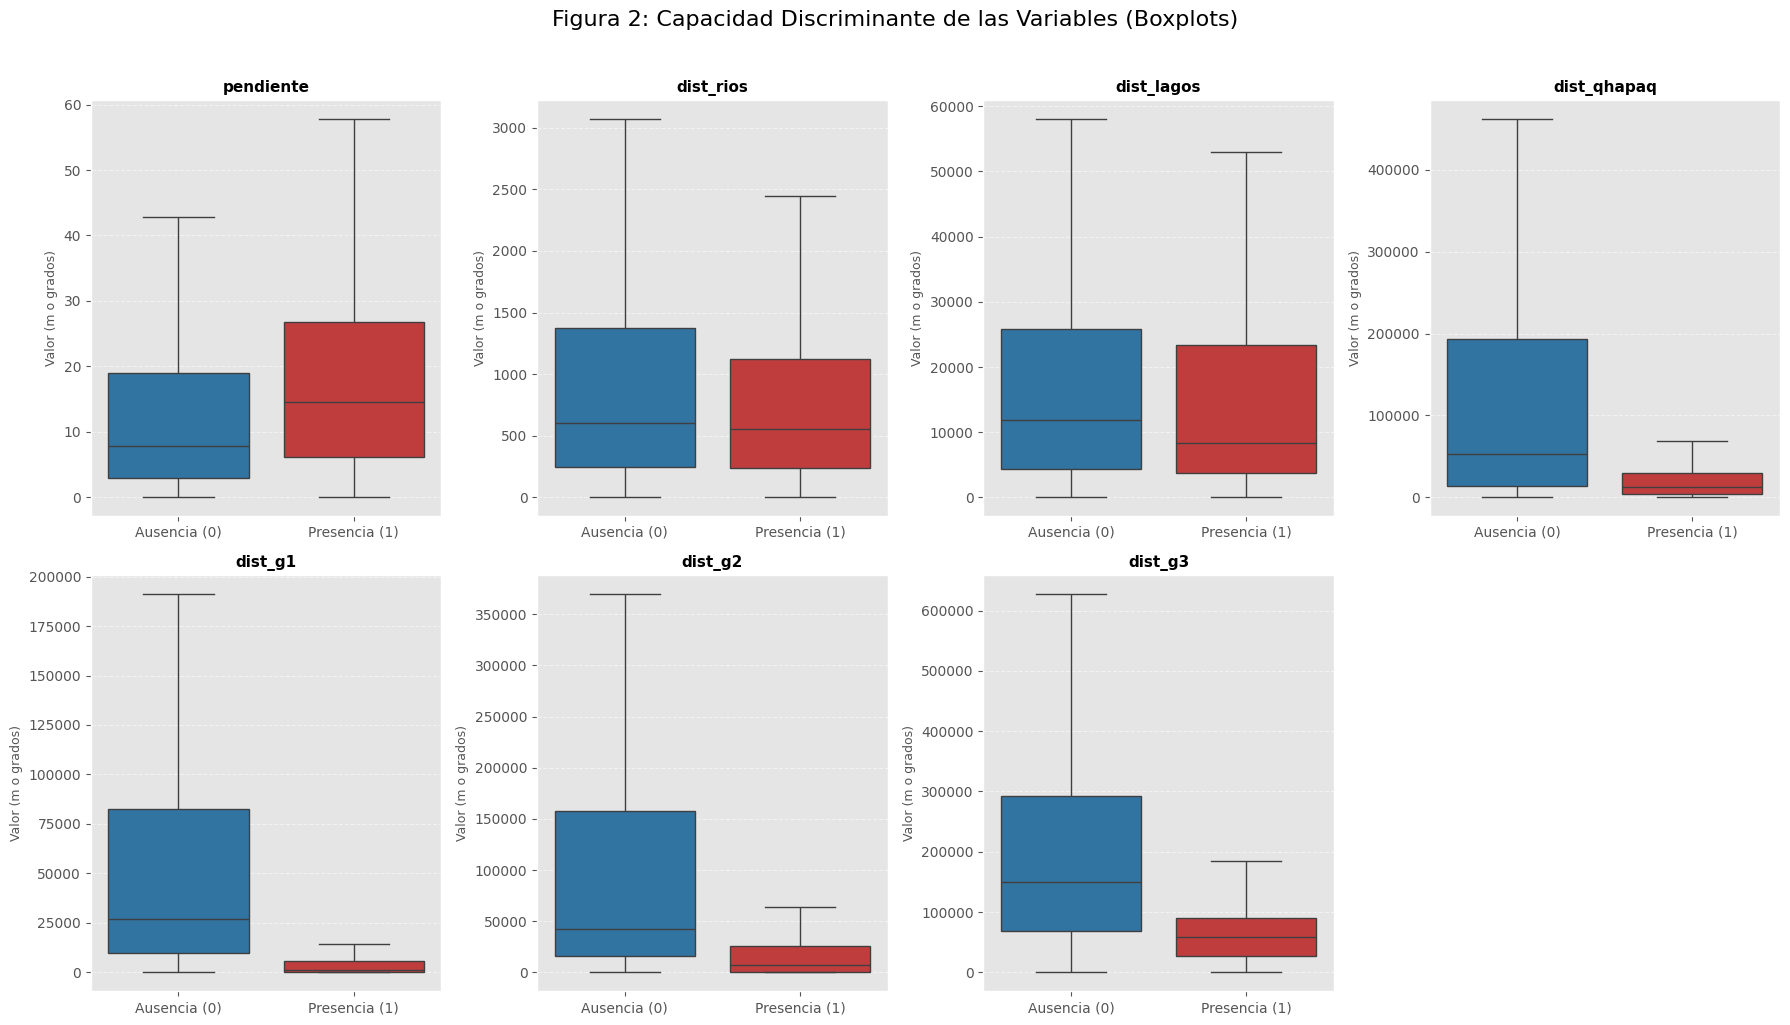

In [13]:
# ==============================================================================
# 2. ANÁLISIS DE SEPARABILIDAD (Boxplots)
# ==============================================================================
print("\nGenerando Boxplots Comparativos...")

# Grid de 2 filas x 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

# Paleta de colores asegurada
mi_paleta = {0: "#1f77b4", 1: "#d62728"}

for i, col in enumerate(cols_features):
    sns.boxplot(x='Target', y=col, data=df, ax=axes[i],
                palette=mi_paleta,
                hue='Target', 
                legend=False,
                showfliers=False) # Sin puntos extremos para limpieza visual
    
    axes[i].set_title(f'{col}', fontweight='bold', fontsize=11)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Valor (m o grados)', fontsize=9)
    axes[i].set_xticklabels(['Ausencia (0)', 'Presencia (1)'])
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.5)

# Borrar el gráfico vacío (el octavo espacio, ya que solo tenemos 7 variables)
if len(cols_features) < 8:
    fig.delaxes(axes[7])

plt.suptitle('Figura 2: Capacidad Discriminante de las Variables (Boxplots)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **3. Preprocesamiento y Partición de Datos**

Para garantizar la validez científica del modelo y evitar el sobreajuste (*overfitting*), se aplica un protocolo estricto de división de datos.

* **Partición Estratificada:** Se divide el dataset en **Entrenamiento (70%)** y **Prueba (30%)**, manteniendo la proporción original de presencias y ausencias en ambos subconjuntos.
* **Escalamiento (Opcional):** Para modelos sensibles a la magnitud (como SVM o Regresión Logística), se estandarizan las variables ($media=0, desv=1$).

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# 1. DEFINICIÓN DE MATRICES (X, y)
# ==============================================================================
print("--- 1. Preparando Matrices ---")
# X: Variables Predictoras (Lo que el modelo usa para pensar)
X = df[cols_features]

# y: Variable Objetivo (La respuesta correcta)
y = df['Target']

print(f"Features (X): {X.shape}")
print(f"Target (y):   {y.shape}")

# ==============================================================================
# 2. PARTICIÓN ESTRATIFICADA (70% Train - 30% Test)
# ==============================================================================
# stratify=y asegura que si hay 50% de sitios en el total, haya 50% en el train y 50% en test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y
)

print(f"\n--- 2. División de Datos (Data Splitting) ---")
print(f"Conjunto de Entrenamiento (Train): {X_train.shape[0]} muestras")
print(f"Conjunto de Prueba (Test):         {X_test.shape[0]} muestras (Bóveda secreta)")

# ==============================================================================
# 3. ESCALAMIENTO DE VARIABLES (StandardScaler)
# ==============================================================================
# Es vital para modelos como SVM o Regresión Logística.
# Random Forest no lo necesita estrictamente, pero no le hace daño.

scaler = StandardScaler()

# ¡OJO! Solo ajustamos (fit) con el TRAIN para no "espiar" el TEST (Data Leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos a DataFrame para mantener los nombres de las columnas (estética)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols_features)

print("\n--- 3. Muestra de Datos Escalados (Primeras 3 filas) ---")
# Ahora verás números pequeños (ej: -1.2, 0.5) en lugar de miles de metros
display(X_train_scaled.head(3))

print("\n✅ Preprocesamiento completado. Listos para entrenar.")

--- 1. Preparando Matrices ---
Features (X): (27047, 7)
Target (y):   (27047,)

--- 2. División de Datos (Data Splitting) ---
Conjunto de Entrenamiento (Train): 18932 muestras
Conjunto de Prueba (Test):         8115 muestras (Bóveda secreta)

--- 3. Muestra de Datos Escalados (Primeras 3 filas) ---


,pendiente,dist_rios,dist_lagos,dist_qhapaq,dist_g1,dist_g2,dist_g3
0,-1.019961,-0.455062,2.965699,-0.595023,-0.575520,-0.579710,-0.693386
1,0.600051,-0.524538,-0.051480,-0.385407,-0.596812,-0.116700,-0.225996
2,-0.800322,-0.293971,-0.757374,-0.447528,-0.503274,-0.548685,-0.857938



✅ Preprocesamiento completado. Listos para entrenar.


### **4. Entrenamiento de Modelos (Benchmark)**

Se entrenan y comparan tres algoritmos de naturaleza distinta para identificar el más robusto para este territorio:

1.  **Regresión Logística (Baseline):** Modelo lineal clásico. Sirve como línea base de comparación.
2.  **Random Forest (Bagging):** Algoritmo de ensamble basado en árboles de decisión. Robusto ante ruido y no requiere escalamiento.
3.  **XGBoost (Boosting):** Estado del arte en datos tabulares. Construye árboles secuenciales para corregir errores previos. Suele ofrecer la mayor métrica de AUC.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time

print("--- 🏁 INICIANDO TORNEO DE MODELOS ---")

# Diccionario para guardar los modelos entrenados
modelos = {}

# ==============================================================================
# 1. REGRESIÓN LOGÍSTICA (Baseline)
# ==============================================================================
print("\n🤖 Entrenando Modelo 1: Regresión Logística...")
start = time.time()

# Usamos datos ESCALADOS (X_train_scaled)
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

end = time.time()
modelos['Logistic Regression'] = log_reg
print(f"✅ Terminado en {round(end - start, 3)} segundos.")

# ==============================================================================
# 2. RANDOM FOREST (Bagging)
# ==============================================================================
print("\n🌲 Entrenando Modelo 2: Random Forest...")
start = time.time()

# Usamos datos ORIGINALES (X_train) - Los árboles no necesitan escalamiento
# n_estimators=100: Creamos 100 árboles de decisión
# n_jobs=-1: Usa todos los núcleos de tu procesador para ir rápido
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

end = time.time()
modelos['Random Forest'] = rf_model
print(f"✅ Terminado en {round(end - start, 3)} segundos.")

# ==============================================================================
# 3. XGBOOST (Boosting)
# ==============================================================================
print("\n🚀 Entrenando Modelo 3: XGBoost (Extreme Gradient Boosting)...")
start = time.time()

# XGBoost es famoso por ganar competencias de Kaggle
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

end = time.time()
modelos['XGBoost'] = xgb_model
print(f"✅ Terminado en {round(end - start, 3)} segundos.")

print("\n ¡ENTRENAMIENTO COMPLETADO! Los 3 modelos están listos para el examen.")

--- 🏁 INICIANDO TORNEO DE MODELOS ---

🤖 Entrenando Modelo 1: Regresión Logística...
✅ Terminado en 0.099 segundos.

🌲 Entrenando Modelo 2: Random Forest...
✅ Terminado en 0.435 segundos.

🚀 Entrenando Modelo 3: XGBoost (Extreme Gradient Boosting)...
✅ Terminado en 0.5 segundos.

 ¡ENTRENAMIENTO COMPLETADO! Los 3 modelos están listos para el examen.


### **5. Evaluación del Desempeño**

Se utilizan métricas objetivas para cuantificar la fiabilidad de las predicciones en el conjunto de prueba (datos desconocidos por el modelo).

#### **5.1 Curvas ROC y Precisión Global**
**Gráfico Clave:** Curva ROC (Receiver Operating Characteristic).
* **Métrica:** AUC (Area Under Curve). Un valor de 0.5 es azar; 1.0 es perfección. En arqueología, $>0.80$ se considera excelente.

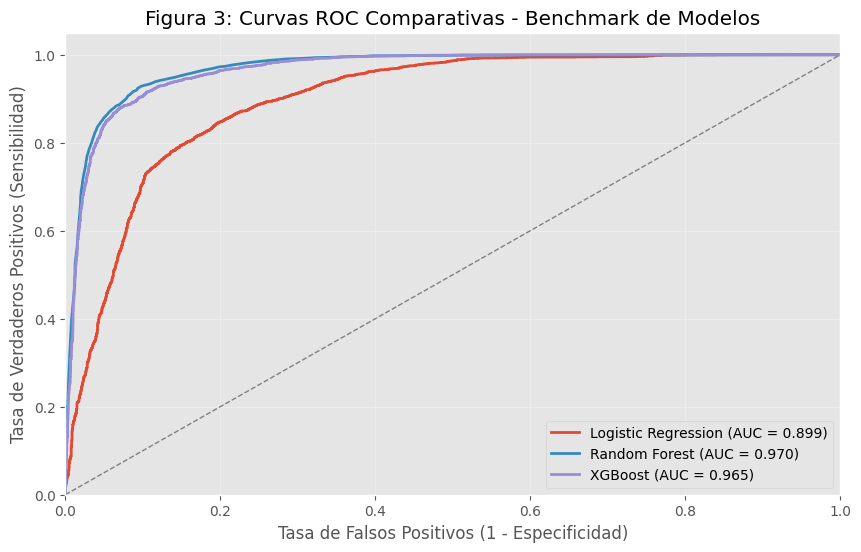

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 5.1 CURVAS ROC Y AUC (Comparativa Gráfica)
# ==============================================================================
plt.figure(figsize=(10, 6))

resultados = {} # Para guardar métricas y usarlas luego

for nombre, modelo in modelos.items():
    # A. Selección de datos correctos (Escalados vs Originales)
    if nombre == 'Logistic Regression':
        X_eval = X_test_scaled
    else:
        X_eval = X_test # RF y XGBoost usan datos originales
        
    # B. Predicción de Probabilidades (necesario para curva ROC)
    # .predict_proba() devuelve [prob_clase_0, prob_clase_1]. Tomamos la columna 1.
    y_prob = modelo.predict_proba(X_eval)[:, 1]
    
    # C. Cálculo de ROC y AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Guardamos para el reporte escrito
    resultados[nombre] = {'AUC': roc_auc, 'X_eval': X_eval}
    
    # D. Graficar
    plt.plot(fpr, tpr, lw=2, label=f'{nombre} (AUC = {roc_auc:.3f})')

# Línea base (azar)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Figura 3: Curvas ROC Comparativas - Benchmark de Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

#### **5.2 Matriz de Confusión**
**Gráfico Clave:** Mapa de calor de aciertos y errores.
* **Análisis:** Nos interesa minimizar los *Falsos Negativos* (no detectar un sitio que sí existe), lo cual se mide con la métrica de **Sensibilidad (Recall)**.


Generando Matrices de Confusión...


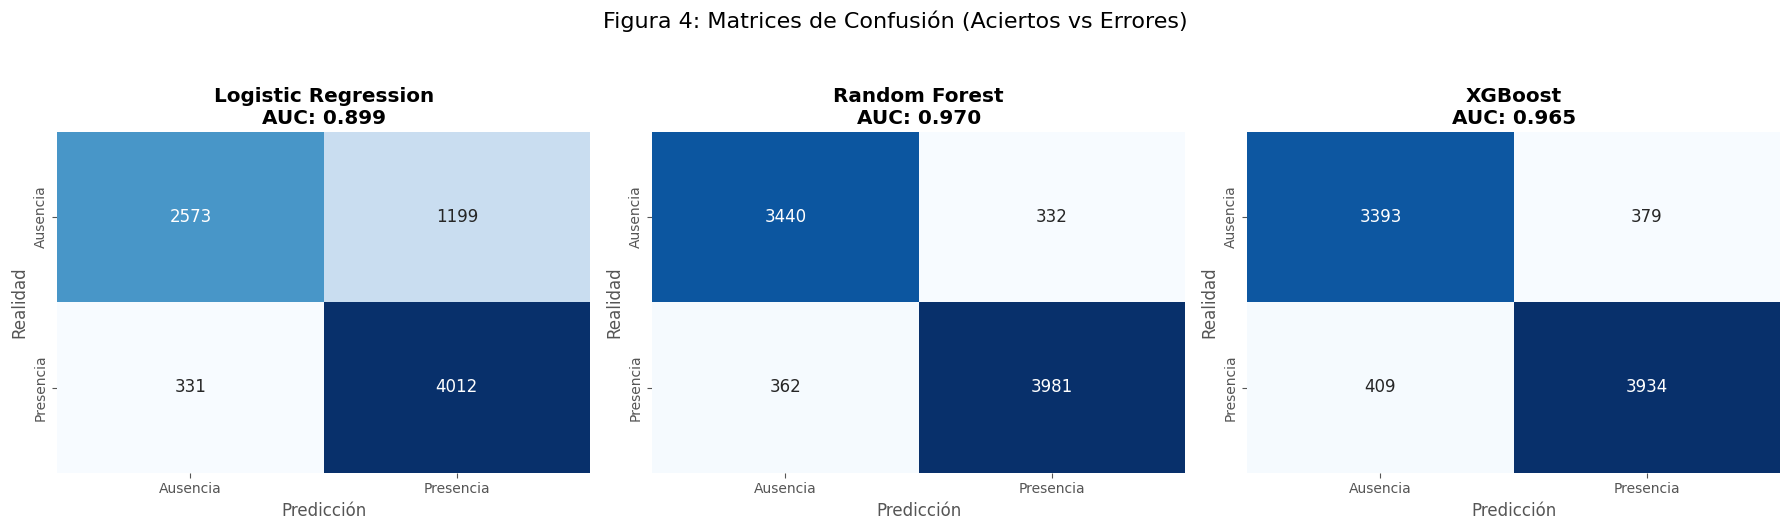


--- 📋 REPORTE TÉCNICO FINAL ---
 EL GANADOR ES: RANDOM FOREST

🔹 Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      3772
           1       0.77      0.92      0.84      4343

    accuracy                           0.81      8115
   macro avg       0.83      0.80      0.81      8115
weighted avg       0.82      0.81      0.81      8115


🔹 Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3772
           1       0.92      0.92      0.92      4343

    accuracy                           0.91      8115
   macro avg       0.91      0.91      0.91      8115
weighted avg       0.91      0.91      0.91      8115


🔹 XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3772
           1       0.91      0.91      0.91      4343

    accuracy                           0.90      8115
   macro av

In [21]:
# ==============================================================================
# 5.2 MATRICES DE CONFUSIÓN (Mapa de Errores)
# ==============================================================================
print("\nGenerando Matrices de Confusión...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

for i, (nombre, modelo) in enumerate(modelos.items()):
    # Recuperamos los datos de prueba correctos
    X_eval = resultados[nombre]['X_eval']
    
    # Predicción dura (0 o 1)
    y_pred = modelo.predict(X_eval)
    
    # Matriz
    cm = confusion_matrix(y_test, y_pred)
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], annot_kws={"size": 12})
    axes[i].set_title(f'{nombre}\nAUC: {resultados[nombre]["AUC"]:.3f}', fontweight='bold')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Realidad')
    axes[i].set_xticklabels(['Ausencia', 'Presencia'])
    axes[i].set_yticklabels(['Ausencia', 'Presencia'])

plt.suptitle('Figura 4: Matrices de Confusión (Aciertos vs Errores)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# ==============================================================================
# 5.3 REPORTE NUMÉRICO DETALLADO
# ==============================================================================
print("\n--- 📋 REPORTE TÉCNICO FINAL ---")
mejor_modelo_nombre = max(resultados, key=lambda x: resultados[x]['AUC'])
print(f" EL GANADOR ES: {mejor_modelo_nombre.upper()}")

for nombre, modelo in modelos.items():
    print(f"\n🔹 {nombre}:")
    X_eval = resultados[nombre]['X_eval']
    y_pred = modelo.predict(X_eval)
    print(classification_report(y_test, y_pred))

### **6. Interpretación del Modelo (Feature Importance)**

**Pregunta de Investigación:** ¿Qué variables ambientales determinaron la ubicación de los sitios arqueológicos?

Se extrae la **Importancia de Gini** (o Permutación) del modelo ganador. Esto permite rankear las variables (ej: *Distancia a Ríos* vs *Pendiente*) y generar conclusiones arqueológicas sobre los patrones de asentamiento.

--- 🧠 ANÁLISIS DE INTERPRETACIÓN DEL MODELO GANADOR (Random Forest) ---

Ranking de Influencia (Gini Importance):


,Variable,Importancia
4,dist_g1,0.307875
5,dist_g2,0.187425
6,dist_g3,0.178588
3,dist_qhapaq,0.155190
2,dist_lagos,0.065806
0,pendiente,0.058331
1,dist_rios,0.046786


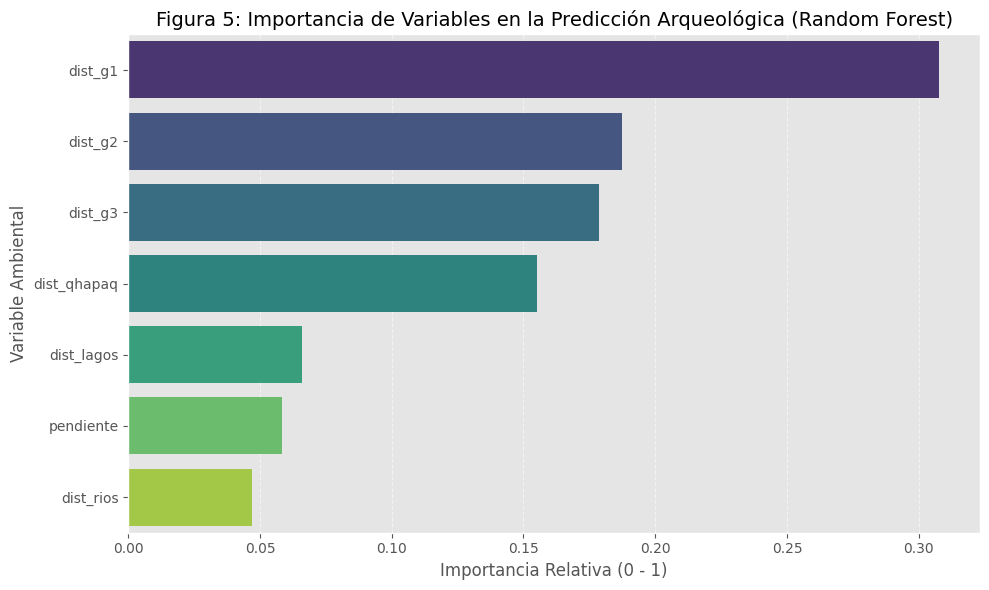


📝 CONCLUSIÓN PARA EL ARTÍCULO:
El modelo Random Forest determinó que 'dist_g1' es el predictor más fuerte, seguido por 'dist_g2'.
Esto sugiere que la ubicación de los sitios está condicionada principalmente por estos factores.


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 6. INTERPRETACIÓN DE VARIABLES (Feature Importance)
# ==============================================================================
print("--- 🧠 ANÁLISIS DE INTERPRETACIÓN DEL MODELO GANADOR (Random Forest) ---")

# 1. Extraer la importancia de las variables del modelo entrenado
# (Usamos rf_model porque fue el ganador)
importancias = rf_model.feature_importances_
nombres_vars = cols_features

# 2. Crear un DataFrame para ordenar los datos
df_importancia = pd.DataFrame({
    'Variable': nombres_vars,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print("\nRanking de Influencia (Gini Importance):")
display(df_importancia)

# 3. Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importancia', 
    y='Variable', 
    data=df_importancia, 
    palette='viridis'
)

plt.title('Figura 5: Importancia de Variables en la Predicción Arqueológica (Random Forest)', fontsize=14)
plt.xlabel('Importancia Relativa (0 - 1)')
plt.ylabel('Variable Ambiental')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Interpretación Automática para tu Paper
top_1 = df_importancia.iloc[0]['Variable']
top_2 = df_importancia.iloc[1]['Variable']
print(f"\n📝 CONCLUSIÓN PARA EL ARTÍCULO:")
print(f"El modelo Random Forest determinó que '{top_1}' es el predictor más fuerte, "
      f"seguido por '{top_2}'.")
print("Esto sugiere que la ubicación de los sitios está condicionada principalmente por estos factores.")

### **7. Guardado del Modelo Final**

Se serializa (guarda) el modelo con mejor desempeño para su posterior uso en la generación del Mapa de Potencial Arqueológico (Notebook 3).

In [1]:
import joblib
import os

# ==============================================================================
# 7. GUARDADO DEL MODELO (Serialización)
# ==============================================================================
print("--- 💾 GUARDANDO EL CEREBRO DE LA IA ---")

# Crear carpeta de modelos si no existe
ruta_carpeta_modelos = '../models'
if not os.path.exists(ruta_carpeta_modelos):
    os.makedirs(ruta_carpeta_modelos)

# Rutas de archivo
ruta_modelo = os.path.join(ruta_carpeta_modelos, 'modelo_random_forest_final.pkl')
ruta_scaler = os.path.join(ruta_carpeta_modelos, 'scaler_entrenamiento.pkl') # Opcional, por si acaso

# Guardamos el modelo ganador (RF)
joblib.dump(rf_model, ruta_modelo)

# Guardamos también el scaler (aunque RF no lo use obligatoriamente, es buena práctica tenerlo)
joblib.dump(scaler, ruta_scaler)

print(f"✅ Modelo guardado exitosamente en:\n   -> {ruta_modelo}")
print("   (Listo para usarse en el Notebook 3: Generación del Mapa)")

--- 💾 GUARDANDO EL CEREBRO DE LA IA ---


NameError: name 'rf_model' is not defined